In [1]:
import torch 
from utils import extract_pool
import matplotlib.pyplot as plt 
import time
from scipy.spatial.distance import pdist, squareform
import numpy as np 

/usr/local/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Loading lookup from /usr/local/lib/python3.7/site-packages/brainio_collection/lookup.csv


/usr/local/lib/python3.7/site-packages/brainio_base/assemblies.py:224: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)


In [2]:

def create_rdm(patterns, vec=False, distance='correlation'):
    rdm_vec = pdist(patterns, distance)
    if not vec:
        return squareform(rdm_vec)
    return rdm_vec


def second_order_rdm(patterns_list, vec=False, distance='correlation'):
    rdm_vecs = np.array([create_rdm(patterns, True, distance) for patterns in patterns_list])
    rdm2_vec = pdist(rdm_vecs, distance)
    if not vec:
        return squareform(rdm2_vec)
    return rdm2_vec

In [50]:
@torch.no_grad()
def pt_create_corr_rdm_v2(X,Y=None,vec=False):
    X_demean=(X-X.mean(axis=1,keepdim=True))
    #X_norm=torch.div(X_demean,X_demean.norm(dim=1,keepdim=True))
    X_norm=torch.nn.functional.normalize(X_demean)
    if Y is not None:
            Y_demean=(Y-Y.mean(axis=1,keepdim=True))
            #Y_norm=torch.div(Y_demean,Y_demean.norm(dim=1,keepdim=True))
            Y_norm=torch.nn.functional.normalize(Y_demean)
    else:
        Y_norm=X_norm
        
    #XY_corr=1-torch.mm(X_norm,torch.transpose(Y_norm,1,0))
    XY_corr=torch.mm(X_norm,torch.transpose(Y_norm,1,0))
    N=XY_corr.shape[1]
    #fixer=torch.ones(N,N,dtype=float,device=device,requires_grad=False)
    XY_corr=torch.triu(torch.sub(fixer,XY_corr),diagonal=1)
    XY_corr=torch.triu(torch.sub(fixer,XY_corr),diagonal=1)
    if vec:
        return torch.clamp(torch.reshape(XY_corr,(1,-1)), 0.0, np.inf)
    return torch.clamp(XY_corr, 0.0, np.inf)



In [81]:
@torch.no_grad()
def pt_create_corr_rdm_short(X,Y=None,vec=False):
    X=(X-X.mean(axis=1,keepdim=True))
    #X=torch.nn.functional.normalize(X)
    if Y is not None:
            Y=(Y-Y.mean(axis=1,keepdim=True))
            #Y_norm=torch.div(Y_demean,Y_demean.norm(dim=1,keepdim=True))
            Y=torch.nn.functional.normalize(Y)
    else:
        Y=X
    XY_corr=1-torch.mm(X,torch.transpose(Y,1,0))
    XY_corr=torch.triu(XY_corr,diagonal=1)
    if vec:
        return torch.clamp(torch.reshape(XY_corr,(1,-1)), 0.0, np.inf)
    return torch.clamp(XY_corr, 0.0, np.inf)

In [ ]:
@torch.no_grad()
def pt_create_corr_rdm_short(X,Y=None,vec=False,device=None):
    X=(X-X.mean(axis=1,keepdim=True))
    X=torch.nn.functional.normalize(X)
    if Y is not None:
            Y=(Y-Y.mean(axis=1,keepdim=True))
            Y=torch.nn.functional.normalize(Y)
    else:
        Y=X
    XY_corr=torch.tensor(1,device=device,dtype=float)-torch.mm(X,torch.transpose(X,1,0))
    XY_corr=torch.triu(XY_corr,diagonal=1)
    if vec:
        return torch.clamp(torch.reshape(XY_corr,(1,-1)), 0.0, np.inf)
    return torch.clamp(XY_corr, 0.0, np.inf)

In [85]:
@torch.no_grad()
def pt_second_order_rdm_v2(X_list):
    XY_corr_list=torch.stack([pt_create_corr_rdm_short(p,vec=False) for p in X_list])
    N1=XY_corr_list.shape[1]
    correction=N1*N1/(N1*(N1-1)/2)
    XY_fix=correction*XY_corr_list.mean(dim=(1,2)).unsqueeze(0)
    fix_mat=torch.triu(1-torch.eye(N1,N1,dtype=float,device=device,requires_grad=False)).unsqueeze(0)
    new=(fix_mat.permute(2,1,0).matmul(XY_fix)).permute(2,1,0)
    XY_corr_demean=XY_corr_list-new
    XY_mean=torch.flatten(XY_corr_demean,start_dim=1)
    XY_norm=torch.nn.functional.normalize(XY_mean,dim=1)
    XY_corr=1-torch.mm(XY_norm,torch.transpose(XY_norm,1,0))
    return XY_corr

In [32]:
@torch.jit.script
def rdm_sub(x):
    return torch.sub(1,x)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [6]:
N=8
D=1000
x=np.random.normal(size=(N, D))
y=np.random.normal(size=(N, D))
x_list=[np.random.normal(size=( N, D)) for k in range(7)]
X_list=[torch.tensor(x).to(device) for x in x_list]
X = torch.tensor(x).to(device)
Y = torch.tensor(y).to(device)

In [7]:
x_corr=create_rdm(x,vec=True)
y_corr=create_rdm(y,vec=True)
pdist(np.array([x_corr,y_corr]),'correlation')

array([0.87044187])

In [83]:
timeit -n 10 pt_create_corr_rdm_short(X)

380 µs ± 214 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


tensor([1.], device='cuda:0', dtype=torch.float64)

In [8]:
x_dmean=x_corr-np.mean(x_corr)
print(f"x mean: {np.mean(x_corr)}")
print(f"x norm: {np.linalg.norm(x_dmean)}")
x_norm=x_dmean/np.linalg.norm(x_dmean)

y_dmean=y_corr-np.mean(y_corr)
print(f"y mean: {np.mean(y_corr)}")
print(f"y norm: {np.linalg.norm(y_dmean)}")
y_norm=y_dmean/np.linalg.norm(y_dmean)

print(f"x_dmean *y_dmean: {np.matmul(x_dmean,y_dmean)}")
1-np.matmul(x_norm,y_norm)



x mean: 1.0012642745753249
x norm: 0.04757941602566812
y mean: 0.9989058531920175
y norm: 0.03750213827806507
x_dmean *y_dmean: 0.00023117443010475266


0.8704418739999557

In [87]:
%timeit -n 10 pt_create_corr_rdm_v2(X,vec=False)


555 µs ± 267 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [88]:
%timeit -n 10 pt_second_order_rdm_v2([X,Y])

1.55 ms ± 651 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
%timeit -n 10 pt_second_order_rdm_v2(X_list)

4.71 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
%timeit -n 10 second_order_rdm(x_list)

171 ms ± 6.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


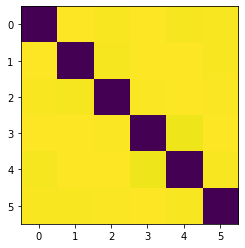

In [228]:
plt.imshow(pt_second_order_rdm_v2(X_list).cpu())


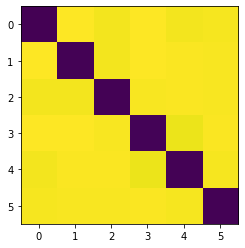

In [234]:
plt.imshow(second_order_rdm(x_list)-pt_second_order_rdm_v2(X_list).cpu().numpy())


In [57]:
X1_demean=X_corr-X1.mean()*torch.triu(1 - torch.eye(N, N)).to(device)
X1_norm=torch.div(X1_demean,X1_demean.norm()).reshape(1,-1)
Y1_demean=Y_corr-(correction*Y_corr).mean()*torch.triu(1 - torch.eye(N, N)).to(device)
Y1_norm=torch.div(Y1_demean,Y1_demean.norm()).reshape(1,-1)

In [60]:
1-torch.mm(X1_norm,torch.transpose(Y1_norm,1,0))

tensor([[0.8704]], device='cuda:0', dtype=torch.float64)

In [74]:
X_list=[X,Y]
XY_corr_list=torch.stack([pt_create_corr_rdm_v2(p,vec=False) for p in X_list])

In [135]:
XY_fix=correction*XY_corr_list.mean(dim=(1,2)).unsqueeze(0)
fix_mat=torch.triu(1-torch.eye(N,N,dtype=float,device=device)).unsqueeze(0)
new=(fix_mat.permute(2,1,0).matmul(XY_fix)).permute(2,1,0)
XY_corr_demean=XY_corr_list-new

In [154]:
XY_mean=torch.flatten(XY_corr_demean,start_dim=1)
XY_mean.norm()

In [126]:
fix_mat=torch.triu(1-torch.eye(N,N,dtype=float,device=device)).unsqueeze(0)
new=fix_mat.permute(2,1,0).matmul(XY_fix)

In [173]:
XY_norm=torch.nn.functional.normalize(XY_mean,dim=1)
XY_norm

tensor([[ 0.0000,  0.2909, -0.1420,  0.3509, -0.5265,  0.0000,  0.0000,  0.1834,
         -0.1653,  0.1295,  0.0000,  0.0000,  0.0000, -0.4274, -0.1530,  0.0000,
          0.0000,  0.0000,  0.0000,  0.4594,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000, -0.0053,  0.1783,  0.3919, -0.0936,  0.0000,  0.0000, -0.8178,
         -0.1823,  0.2644,  0.0000,  0.0000,  0.0000,  0.0317,  0.0623,  0.0000,
          0.0000,  0.0000,  0.0000,  0.1704,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000]], device='cuda:0', dtype=torch.float64)

array([-0.00532935,  0.1782659 ,  0.39194706, -0.09358579, -0.81776212,
       -0.18232929,  0.26442186,  0.03168882,  0.062307  ,  0.17037591])

In [162]:
XY_mean.norm(dim=1).prod()

tensor(560.4345, device='cuda:0', dtype=torch.float64)

# profiling 

In [7]:
import torch.autograd.profiler as profiler

In [243]:
with profiler.profile(record_shapes=True) as prof:
    with profiler.record_function("model_inference"):
        pt_second_order_rdm_v2(X_list)

In [246]:
print(prof.key_averages().table())

------------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name                                  Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     Number of Calls  
------------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
profiler::_record_function_enter      0.13%            52.137us         0.13%            52.137us         52.137us         1                
model_inference                       24.12%           10.026ms         99.87%           41.515ms         41.515ms         1                
mean                                  70.26%           29.203ms         70.26%           29.203ms         3.650ms          8                
sub                                   0.53%            222.049us        0.53%            222.049us        27.756us         8                
norm        

In [250]:
import torch.autograd.profiler as gpu_profiler


In [96]:
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    pt_second_order_rdm_v2(X_list)
print(prof.key_averages().table()) 

----------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name              Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    Number of Calls  
----------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
mean              13.23%           544.907us        13.23%           544.907us        68.113us         2.76%            229.376us        28.672us         8                
sub               11.54%           474.983us        11.54%           474.983us        59.373us         3.48%            288.608us        36.076us         8                
transpose         4.23%            174.129us        4.23%            174.129us        21.766us         0.58%            48.321us         6.

In [261]:
torch.__version__

'1.4.0'

In [101]:
torch.combinations(torch.tensor([1,2,3,4,5,6,7]))

torch.Size([21, 2])

21.0